# Urdu Poetry Generation - Deep Learning Project (Part 2)

This notebook implements the comparative analysis of Sequence-to-Sequence models (RNN, LSTM, Transformer) and optimization algorithms (Adam, RMSprop, SGD) for Urdu poetry generation.

In [ ]:
# Install Dependencies
!pip install torch transformers datasets scikit-learn matplotlib seaborn pandas tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import os
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Set device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


## 1. Data Loader and Preprocessing

In [ ]:
class UrduPoetryTokenizer:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.vocab_size = 0

    def fit_on_texts(self, texts):
        all_words = []
        for text in texts:
            words = self._clean_and_tokenize(text)
            all_words.extend(words)

        word_counts = Counter(all_words)
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

        self.word2idx = {"<PAD>": 0, "<UNK>": 1, "<SOS>": 2, "<EOS>": 3}
        self.idx2word = {0: "<PAD>", 1: "<UNK>", 2: "<SOS>", 3: "<EOS>"}

        idx = 4
        for word, _ in sorted_words:
            if word not in self.word2idx:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        self.vocab_size = len(self.word2idx)
        print(f"Vocabulary size: {self.vocab_size}")

    def _clean_and_tokenize(self, text):
        text = str(text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text.split(' ')

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            words = self._clean_and_tokenize(text)
            seq = [self.word2idx.get(w, self.word2idx["<UNK>"]) for w in words]
            sequences.append(seq)
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for seq in sequences:
            words = [self.idx2word.get(idx, "<UNK>") for idx in seq]
            words = [w for w in words if w not in ["<PAD>", "<SOS>", "<EOS>"]]
            texts.append(" ".join(words))
        return texts

def load_and_process_data(max_seq_len=20, batch_size=128):
    print("Loading dataset...")
    try:
        dataset = load_dataset("ReySajju742/Urdu-Poetry-Dataset")
        data_split = dataset['train'] if 'train' in dataset else dataset['test']

        all_lines = []
        for item in data_split:
            content = item.get('content', '') or item.get('Poem', '') or list(item.values())[0]
            if content:
                lines = content.split('\n')
                all_lines.extend([l for l in lines if l.strip()])

        print(f"Total lines extracted: {len(all_lines)}")

        tokenizer = UrduPoetryTokenizer()
        tokenizer.fit_on_texts(all_lines)

        sequences = tokenizer.texts_to_sequences(all_lines)

        input_sequences = []
        for seq in sequences:
            for i in range(1, len(seq)):
                n_gram_seq = seq[:i+1]
                if len(n_gram_seq) <= max_seq_len + 1:
                    input_sequences.append(n_gram_seq)
                else:
                    input_sequences.append(n_gram_seq[-(max_seq_len+1):])

        print(f"Total sequences created: {len(input_sequences)}")

        padded_sequences = []
        for seq in input_sequences:
            pad_len = (max_seq_len + 1) - len(seq)
            padded_seq = [0] * pad_len + seq
            padded_sequences.append(padded_seq)

        padded_sequences = np.array(padded_sequences)

        X = padded_sequences[:, :-1]
        y = padded_sequences[:, -1]

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long))
        val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val, dtype=torch.long))
        test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        return train_loader, val_loader, test_loader, tokenizer

    except Exception as e:
        print(f"Error in data loading: {e}")
        return None, None, None, None

## 2. Model Architectures

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2, dropout=0.2):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embeds = self.embedding(x)
        output, hidden = self.rnn(embeds, hidden)
        prediction = self.fc(output)
        return prediction, hidden

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embeds = self.embedding(x)
        output, hidden = self.lstm(embeds, hidden)
        prediction = self.fc(output)
        return prediction, hidden

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers=2, dropout=0.2, max_len=100):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len)

        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, vocab_size)
        self.embed_dim = embed_dim

    def forward(self, x, mask=None):
        embeds = self.embedding(x) * math.sqrt(self.embed_dim)
        embeds = self.pos_encoder(embeds)

        if mask is None:
            seq_len = x.size(1)
            mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1)
            mask = mask.to(x.device)

        output = self.transformer_encoder(embeds, mask=mask, is_causal=True)
        prediction = self.fc(output)
        return prediction, None

## 3. Training and Evaluation Functions

In [ ]:
def get_optimizer(model, optimizer_name, learning_rate):
    if optimizer_name.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

def train_epoch(model, dataloader, criterion, optimizer, device, clip=1.0):
    model.train()
    total_loss = 0

    for batch in dataloader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        if isinstance(model, (nn.RNN, nn.LSTM, nn.GRU)):
            outputs, _ = model(inputs)
            output = outputs[:, -1, :]
        else:
            outputs, _ = model(inputs)
            output = outputs[:, -1, :]

        loss = criterion(output, targets)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            if isinstance(model, (nn.RNN, nn.LSTM, nn.GRU)):
                outputs, _ = model(inputs)
                output = outputs[:, -1, :]
            else:
                outputs, _ = model(inputs)
                output = outputs[:, -1, :]

            loss = criterion(output, targets)
            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return total_loss / len(dataloader), correct / total

def train_model(model, train_loader, val_loader, optimizer_name, learning_rate, epochs, device, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, optimizer_name, learning_rate)

    best_val_loss = float('inf')
    patience_counter = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_ppl': [],
        'val_ppl': [],
        'val_acc': []
    }

    start_time = time.time()

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        train_ppl = math.exp(train_loss)
        val_ppl = math.exp(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_ppl'].append(train_ppl)
        history['val_ppl'].append(val_ppl)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val PPL: {val_ppl:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    total_time = time.time() - start_time
    return history, total_time

def generate_text(model, tokenizer, seed_text, max_length=20, temperature=1.0, device='cpu'):
    model.eval()
    words = tokenizer._clean_and_tokenize(seed_text)
    current_seq = [tokenizer.word2idx.get(w, tokenizer.word2idx["<UNK>"]) for w in words]

    generated_words = []

    with torch.no_grad():
        for _ in range(max_length):
            inp = torch.tensor([current_seq], dtype=torch.long).to(device)
            if inp.size(1) > 100:
                 inp = inp[:, -100:]

            if isinstance(model, (torch.nn.RNN, torch.nn.LSTM, torch.nn.GRU)):
                outputs, _ = model(inp)
                output = outputs[:, -1, :]
            else:
                outputs, _ = model(inp)
                output = outputs[:, -1, :]

            output = output / temperature
            probs = F.softmax(output, dim=-1)
            next_token_idx = torch.multinomial(probs, 1).item()

            current_seq.append(next_token_idx)
            word = tokenizer.idx2word.get(next_token_idx, "<UNK>")
            generated_words.append(word)

            if word == "<EOS>":
                break

    return seed_text + " " + " ".join(generated_words)

## 4. Run Experiments

Loading dataset...
Total lines extracted: 21077
Vocabulary size: 10520
Total sequences created: 152146

=== Running Experiment: RNN + Adam ===
Epoch 1/20 | Train Loss: 7.0427 | Val Loss: 6.8520 | Val PPL: 945.7920 | Val Acc: 0.0552
Epoch 2/20 | Train Loss: 6.5840 | Val Loss: 6.6870 | Val PPL: 801.9360 | Val Acc: 0.0737
Epoch 3/20 | Train Loss: 6.1922 | Val Loss: 6.6555 | Val PPL: 777.0321 | Val Acc: 0.0872
Epoch 4/20 | Train Loss: 5.7379 | Val Loss: 6.7338 | Val PPL: 840.3616 | Val Acc: 0.0956
Epoch 5/20 | Train Loss: 5.2863 | Val Loss: 6.8386 | Val PPL: 933.1658 | Val Acc: 0.0912
Epoch 6/20 | Train Loss: 4.8767 | Val Loss: 6.9282 | Val PPL: 1020.6603 | Val Acc: 0.0926
Epoch 7/20 | Train Loss: 4.5319 | Val Loss: 7.0655 | Val PPL: 1170.8106 | Val Acc: 0.0937
Epoch 8/20 | Train Loss: 4.2484 | Val Loss: 7.1818 | Val PPL: 1315.3069 | Val Acc: 0.0918
Early stopping triggered after 8 epochs.
Test Results: Loss=7.1541, PPL=1279.3550, Acc=0.0938

=== Detailed Text Generation Analysis ===

--- 

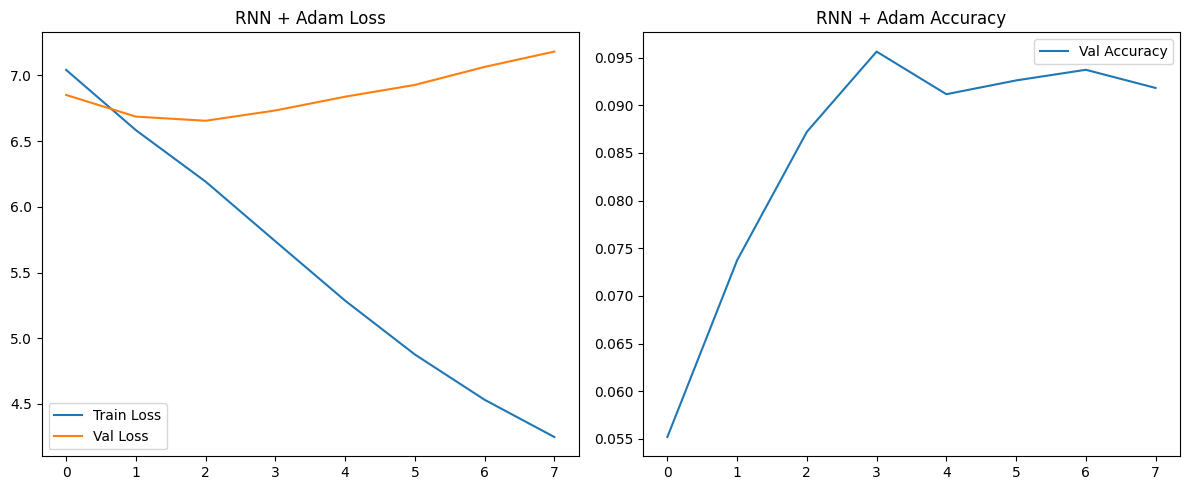


=== Running Experiment: RNN + RMSprop ===
Epoch 1/20 | Train Loss: 7.3800 | Val Loss: 7.3000 | Val PPL: 1480.3164 | Val Acc: 0.0189
Epoch 2/20 | Train Loss: 7.2844 | Val Loss: 7.2536 | Val PPL: 1413.1861 | Val Acc: 0.0452
Epoch 3/20 | Train Loss: 7.2557 | Val Loss: 7.3790 | Val PPL: 1602.0341 | Val Acc: 0.0095
Epoch 4/20 | Train Loss: 7.2461 | Val Loss: 7.2892 | Val PPL: 1464.4694 | Val Acc: 0.0452
Epoch 5/20 | Train Loss: 7.2828 | Val Loss: 7.3180 | Val PPL: 1507.1204 | Val Acc: 0.0452
Epoch 6/20 | Train Loss: 7.2579 | Val Loss: 7.2786 | Val PPL: 1448.9367 | Val Acc: 0.0291
Epoch 7/20 | Train Loss: 7.2657 | Val Loss: 7.2664 | Val PPL: 1431.4361 | Val Acc: 0.0246
Early stopping triggered after 7 epochs.
Test Results: Loss=7.2473, PPL=1404.2895, Acc=0.0239

=== Detailed Text Generation Analysis ===

--- Temperature: 0.7 ---
Seed: محبت | Temp: 0.7 -> محبت بہہ سے عجب اقامت بہہ ہیں عجب شست بہہ اتنی سکنڈ‌ دلال بہہ دل ارماں
Seed: دل | Temp: 0.7 -> دل سے رحمان زنخداں بہہ تھا نصیر زائل بہہ اپ

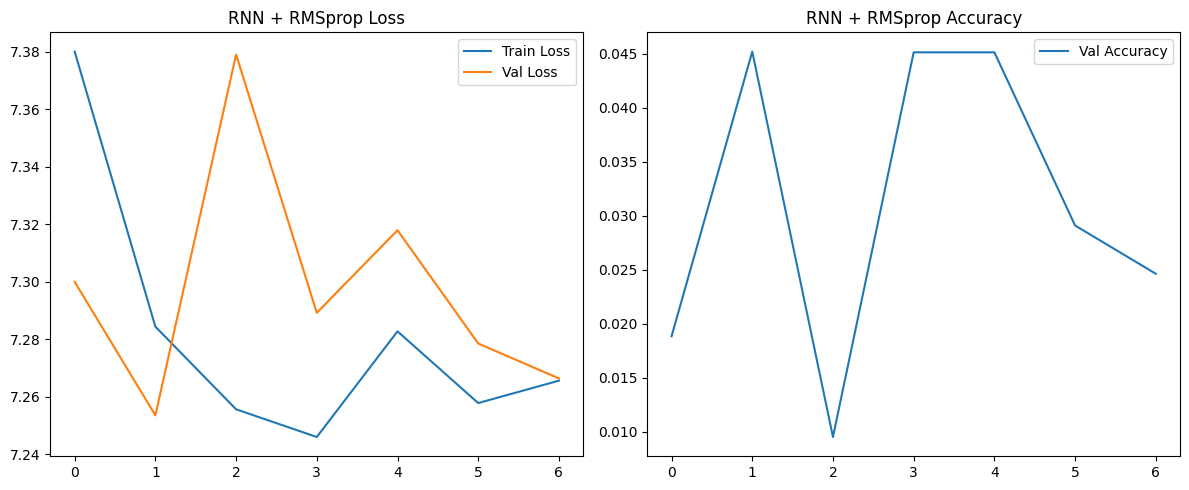


=== Running Experiment: RNN + SGD ===
Epoch 1/20 | Train Loss: 7.9060 | Val Loss: 7.1922 | Val PPL: 1329.0318 | Val Acc: 0.0452
Epoch 2/20 | Train Loss: 7.0777 | Val Loss: 6.9711 | Val PPL: 1065.4170 | Val Acc: 0.0452
Epoch 3/20 | Train Loss: 6.9373 | Val Loss: 6.8912 | Val PPL: 983.5442 | Val Acc: 0.0452
Epoch 4/20 | Train Loss: 6.8741 | Val Loss: 6.8482 | Val PPL: 942.1799 | Val Acc: 0.0452
Epoch 5/20 | Train Loss: 6.8363 | Val Loss: 6.8206 | Val PPL: 916.5372 | Val Acc: 0.0452
Epoch 6/20 | Train Loss: 6.8101 | Val Loss: 6.7996 | Val PPL: 897.5214 | Val Acc: 0.0452
Epoch 7/20 | Train Loss: 6.7895 | Val Loss: 6.7850 | Val PPL: 884.4601 | Val Acc: 0.0452
Epoch 8/20 | Train Loss: 6.7723 | Val Loss: 6.7691 | Val PPL: 870.5155 | Val Acc: 0.0457
Epoch 9/20 | Train Loss: 6.7557 | Val Loss: 6.7560 | Val PPL: 859.1937 | Val Acc: 0.0465
Epoch 10/20 | Train Loss: 6.7393 | Val Loss: 6.7404 | Val PPL: 845.9342 | Val Acc: 0.0469
Epoch 11/20 | Train Loss: 6.7225 | Val Loss: 6.7256 | Val PPL: 833.4

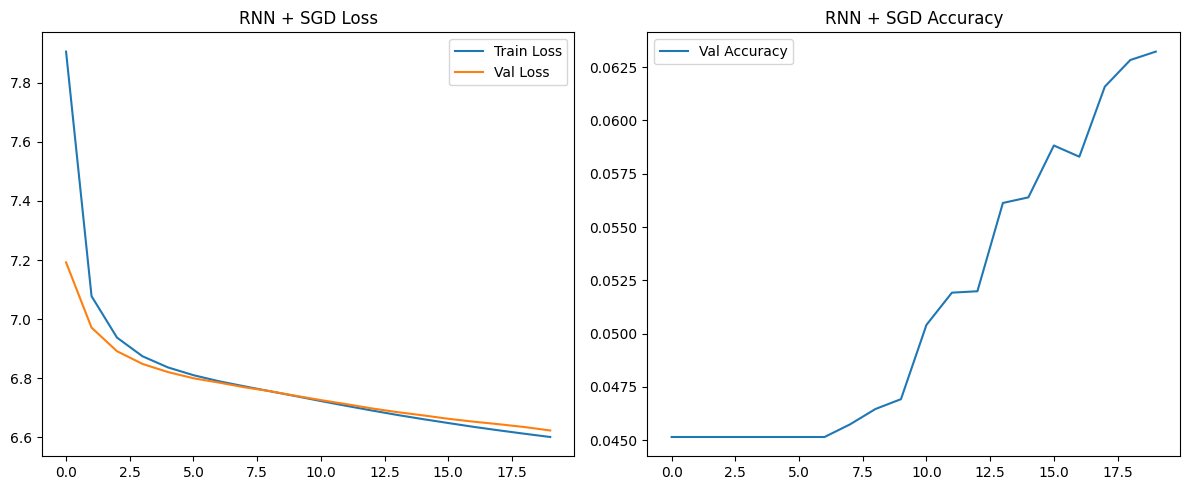


=== Running Experiment: LSTM + Adam ===
Epoch 1/20 | Train Loss: 6.7788 | Val Loss: 6.5230 | Val PPL: 680.6292 | Val Acc: 0.0693
Epoch 2/20 | Train Loss: 6.2836 | Val Loss: 6.3332 | Val PPL: 562.9447 | Val Acc: 0.0870
Epoch 3/20 | Train Loss: 5.9161 | Val Loss: 6.2525 | Val PPL: 519.3084 | Val Acc: 0.0999
Epoch 4/20 | Train Loss: 5.5295 | Val Loss: 6.2768 | Val PPL: 532.1061 | Val Acc: 0.1068
Epoch 5/20 | Train Loss: 5.1064 | Val Loss: 6.3681 | Val PPL: 582.9290 | Val Acc: 0.1139
Epoch 6/20 | Train Loss: 4.6370 | Val Loss: 6.5256 | Val PPL: 682.3797 | Val Acc: 0.1104
Epoch 7/20 | Train Loss: 4.1400 | Val Loss: 6.7440 | Val PPL: 848.9753 | Val Acc: 0.1124
Epoch 8/20 | Train Loss: 3.6859 | Val Loss: 6.9211 | Val PPL: 1013.4152 | Val Acc: 0.1105
Early stopping triggered after 8 epochs.
Test Results: Loss=6.8868, PPL=979.2740, Acc=0.1136

=== Detailed Text Generation Analysis ===

--- Temperature: 0.7 ---
Seed: محبت | Temp: 0.7 -> محبت طالب نہیں رہا ہوں میں بھی بھی بھی نہ رہا مری رنج میں 

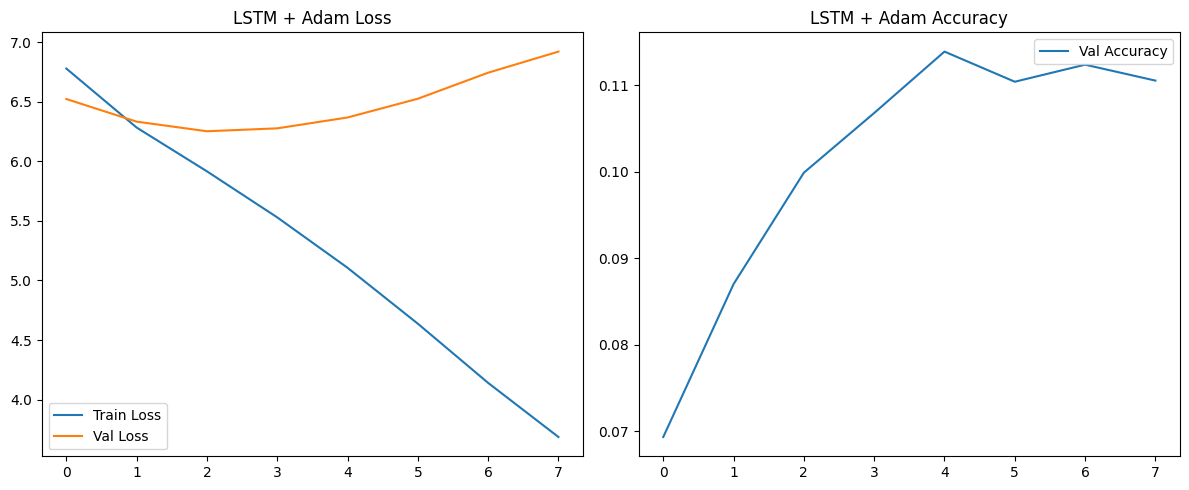


=== Running Experiment: LSTM + RMSprop ===
Epoch 1/20 | Train Loss: 6.6301 | Val Loss: 6.3815 | Val PPL: 590.8376 | Val Acc: 0.0869
Epoch 2/20 | Train Loss: 6.0694 | Val Loss: 6.2585 | Val PPL: 522.4235 | Val Acc: 0.1059
Epoch 3/20 | Train Loss: 5.6262 | Val Loss: 6.2745 | Val PPL: 530.8751 | Val Acc: 0.1113
Epoch 4/20 | Train Loss: 5.1397 | Val Loss: 6.3389 | Val PPL: 566.1509 | Val Acc: 0.1148
Epoch 5/20 | Train Loss: 4.6316 | Val Loss: 6.5564 | Val PPL: 703.7166 | Val Acc: 0.1161
Epoch 6/20 | Train Loss: 4.1232 | Val Loss: 6.7835 | Val PPL: 883.1915 | Val Acc: 0.1127
Epoch 7/20 | Train Loss: 3.6329 | Val Loss: 7.0080 | Val PPL: 1105.4859 | Val Acc: 0.1073
Early stopping triggered after 7 epochs.
Test Results: Loss=6.9784, PPL=1073.2223, Acc=0.1097

=== Detailed Text Generation Analysis ===

--- Temperature: 0.7 ---
Seed: محبت | Temp: 0.7 -> محبت میں جی حدوں ہے کہیں اور مری آوارگی کا نمک لگیں ہیں لگیں گے مری
Seed: دل | Temp: 0.7 -> دل مرا ہستئ ہوشیار ہے سب سے تیری روح عجب ہے فسوں گے

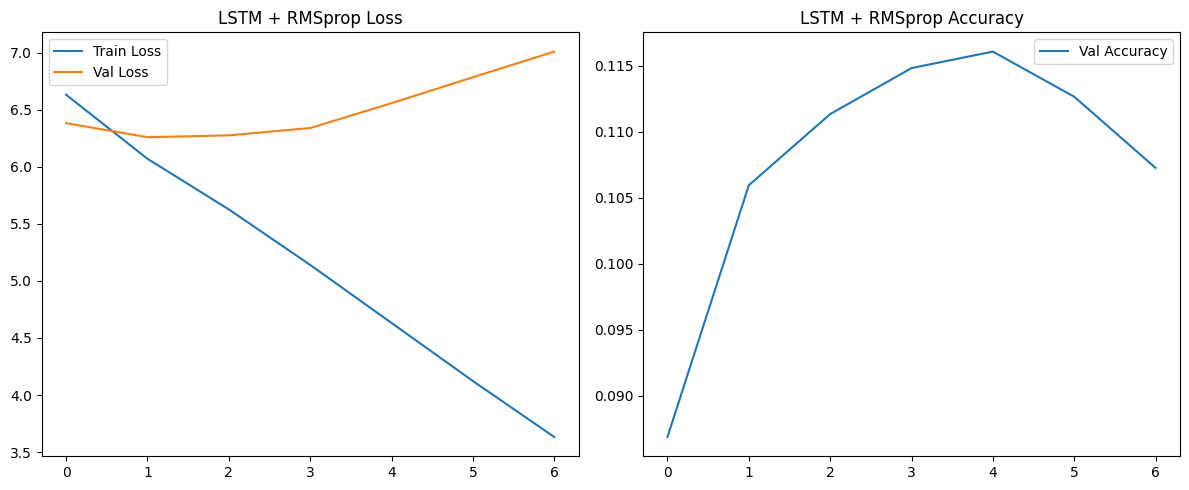


=== Running Experiment: LSTM + SGD ===
Epoch 1/20 | Train Loss: 9.1380 | Val Loss: 8.7333 | Val PPL: 6205.9674 | Val Acc: 0.0452
Epoch 2/20 | Train Loss: 7.6787 | Val Loss: 7.2148 | Val PPL: 1359.4229 | Val Acc: 0.0452
Epoch 3/20 | Train Loss: 7.1015 | Val Loss: 6.9952 | Val PPL: 1091.3425 | Val Acc: 0.0452
Epoch 4/20 | Train Loss: 6.9570 | Val Loss: 6.9105 | Val PPL: 1002.7268 | Val Acc: 0.0452
Epoch 5/20 | Train Loss: 6.8910 | Val Loss: 6.8656 | Val PPL: 958.7582 | Val Acc: 0.0452
Epoch 6/20 | Train Loss: 6.8521 | Val Loss: 6.8364 | Val PPL: 931.1455 | Val Acc: 0.0452
Epoch 7/20 | Train Loss: 6.8256 | Val Loss: 6.8171 | Val PPL: 913.3201 | Val Acc: 0.0452
Epoch 8/20 | Train Loss: 6.8067 | Val Loss: 6.8021 | Val PPL: 899.7096 | Val Acc: 0.0452
Epoch 9/20 | Train Loss: 6.7923 | Val Loss: 6.7916 | Val PPL: 890.3312 | Val Acc: 0.0452
Epoch 10/20 | Train Loss: 6.7811 | Val Loss: 6.7831 | Val PPL: 882.7907 | Val Acc: 0.0452
Epoch 11/20 | Train Loss: 6.7723 | Val Loss: 6.7761 | Val PPL: 87

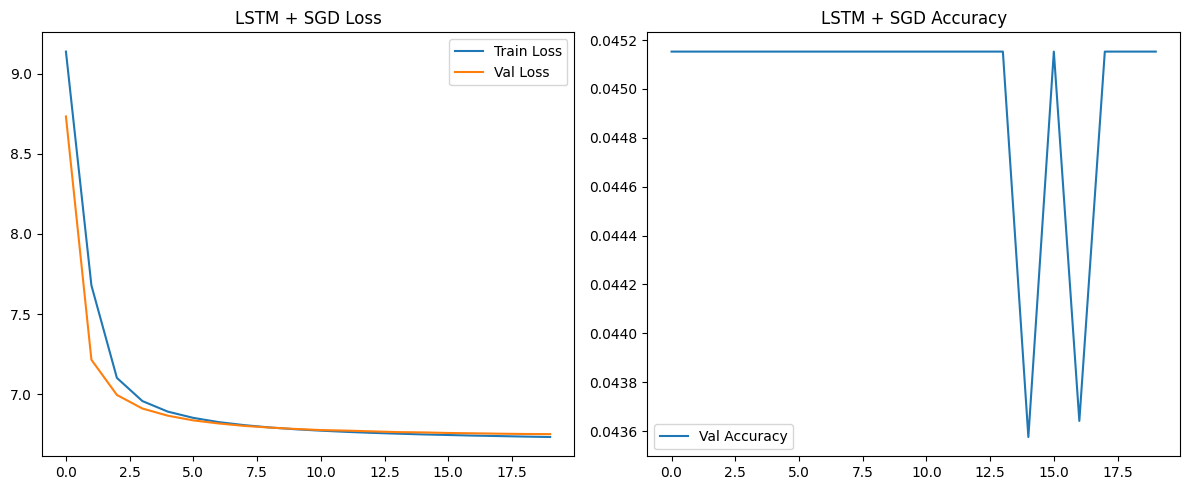


=== Running Experiment: Transformer + Adam ===
Epoch 1/20 | Train Loss: 6.9999 | Val Loss: 6.6944 | Val PPL: 807.9025 | Val Acc: 0.0574
Epoch 2/20 | Train Loss: 6.5443 | Val Loss: 6.5787 | Val PPL: 719.6358 | Val Acc: 0.0694
Epoch 3/20 | Train Loss: 6.3514 | Val Loss: 6.4912 | Val PPL: 659.2838 | Val Acc: 0.0801
Epoch 4/20 | Train Loss: 6.1765 | Val Loss: 6.4395 | Val PPL: 626.0632 | Val Acc: 0.0852
Epoch 5/20 | Train Loss: 6.0174 | Val Loss: 6.3914 | Val PPL: 596.6718 | Val Acc: 0.0875
Epoch 6/20 | Train Loss: 5.8696 | Val Loss: 6.3677 | Val PPL: 582.7202 | Val Acc: 0.0906
Epoch 7/20 | Train Loss: 5.7320 | Val Loss: 6.3607 | Val PPL: 578.6388 | Val Acc: 0.0950
Epoch 8/20 | Train Loss: 5.6018 | Val Loss: 6.3487 | Val PPL: 571.7716 | Val Acc: 0.0993
Epoch 9/20 | Train Loss: 5.4802 | Val Loss: 6.3555 | Val PPL: 575.6585 | Val Acc: 0.1002
Epoch 10/20 | Train Loss: 5.3667 | Val Loss: 6.3581 | Val PPL: 577.1535 | Val Acc: 0.0987
Epoch 11/20 | Train Loss: 5.2547 | Val Loss: 6.3761 | Val PPL

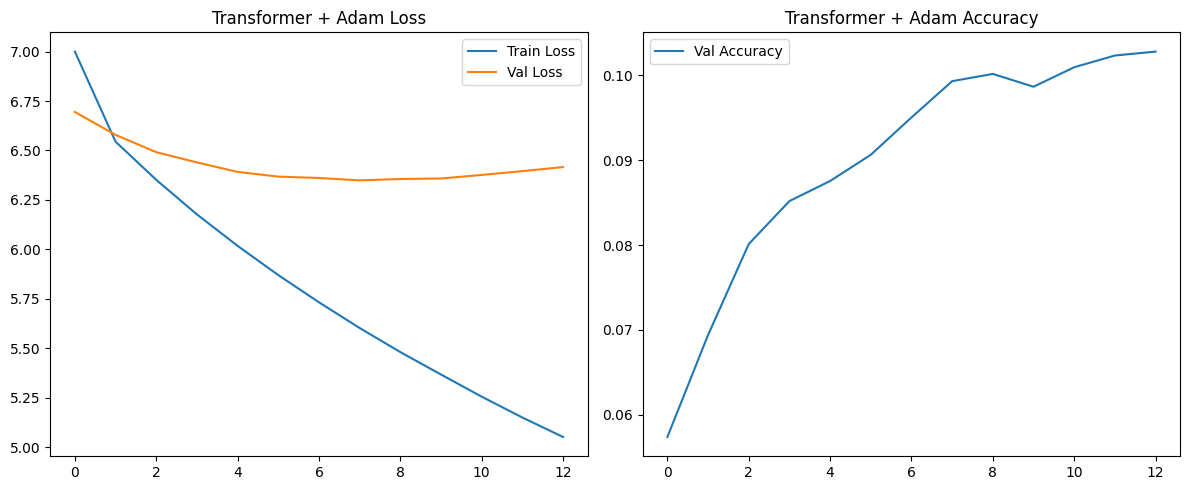


=== Running Experiment: Transformer + RMSprop ===
Epoch 1/20 | Train Loss: 6.9676 | Val Loss: 6.8981 | Val PPL: 990.4255 | Val Acc: 0.0461
Epoch 2/20 | Train Loss: 6.7889 | Val Loss: 6.9583 | Val PPL: 1051.8679 | Val Acc: 0.0497
Epoch 3/20 | Train Loss: 6.7477 | Val Loss: 6.9364 | Val PPL: 1029.0239 | Val Acc: 0.0528
Epoch 4/20 | Train Loss: 6.6987 | Val Loss: 6.9708 | Val PPL: 1065.0481 | Val Acc: 0.0526
Epoch 5/20 | Train Loss: 6.6529 | Val Loss: 6.8508 | Val PPL: 944.6700 | Val Acc: 0.0552
Epoch 6/20 | Train Loss: 6.6110 | Val Loss: 6.9181 | Val PPL: 1010.4184 | Val Acc: 0.0580
Epoch 7/20 | Train Loss: 6.5691 | Val Loss: 6.8239 | Val PPL: 919.6073 | Val Acc: 0.0591
Epoch 8/20 | Train Loss: 6.5369 | Val Loss: 6.8118 | Val PPL: 908.5136 | Val Acc: 0.0616
Epoch 9/20 | Train Loss: 6.5017 | Val Loss: 6.7621 | Val PPL: 864.4373 | Val Acc: 0.0611
Epoch 10/20 | Train Loss: 6.4610 | Val Loss: 6.7594 | Val PPL: 862.0823 | Val Acc: 0.0668
Epoch 11/20 | Train Loss: 6.4203 | Val Loss: 6.6400 | 

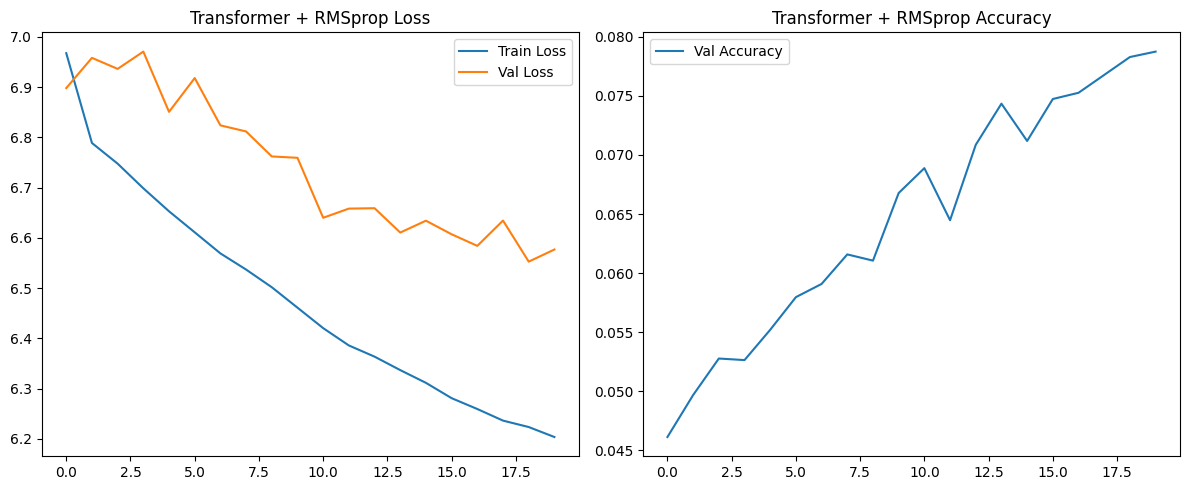


=== Running Experiment: Transformer + SGD ===
Epoch 1/20 | Train Loss: 8.5148 | Val Loss: 7.6302 | Val PPL: 2059.4130 | Val Acc: 0.0446
Epoch 2/20 | Train Loss: 7.4402 | Val Loss: 7.2115 | Val PPL: 1354.9726 | Val Acc: 0.0467
Epoch 3/20 | Train Loss: 7.1621 | Val Loss: 7.0414 | Val PPL: 1142.9980 | Val Acc: 0.0453
Epoch 4/20 | Train Loss: 7.0249 | Val Loss: 6.9495 | Val PPL: 1042.5969 | Val Acc: 0.0454
Epoch 5/20 | Train Loss: 6.9470 | Val Loss: 6.8893 | Val PPL: 981.6689 | Val Acc: 0.0485
Epoch 6/20 | Train Loss: 6.8957 | Val Loss: 6.8502 | Val PPL: 944.0493 | Val Acc: 0.0486
Epoch 7/20 | Train Loss: 6.8563 | Val Loss: 6.8189 | Val PPL: 914.9866 | Val Acc: 0.0517
Epoch 8/20 | Train Loss: 6.8247 | Val Loss: 6.7920 | Val PPL: 890.7351 | Val Acc: 0.0526
Epoch 9/20 | Train Loss: 6.7967 | Val Loss: 6.7730 | Val PPL: 873.9540 | Val Acc: 0.0546
Epoch 10/20 | Train Loss: 6.7731 | Val Loss: 6.7534 | Val PPL: 856.9736 | Val Acc: 0.0565
Epoch 11/20 | Train Loss: 6.7512 | Val Loss: 6.7364 | Val 

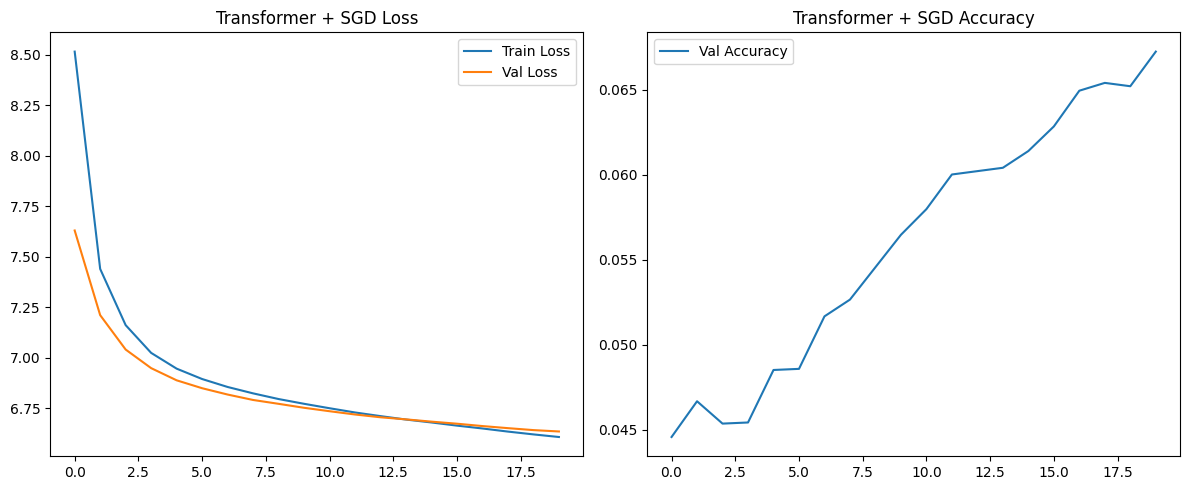

In [19]:
# Configuration
BATCH_SIZE = 128
MAX_SEQ_LEN = 20
EMBED_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 2
EPOCHS = 20 # Full epochs for Colab
PATIENCE = 5

# Load Data
train_loader, val_loader, test_loader, tokenizer = load_and_process_data(max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE)

vocab_size = tokenizer.vocab_size

models_to_test = ['RNN', 'LSTM', 'Transformer']
optimizers_to_test = ['Adam', 'RMSprop', 'SGD']

results = []
if os.path.exists('generated_samples.txt'):
    os.remove('generated_samples.txt')

if not os.path.exists('results'):
    os.makedirs('results')

for model_name in models_to_test:
    for opt_name in optimizers_to_test:
        print(f"\n=== Running Experiment: {model_name} + {opt_name} ===")

        if model_name == 'RNN':
            model = SimpleRNN(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
            lr = 0.001 if opt_name != 'SGD' else 0.01
        elif model_name == 'LSTM':
            model = LSTMModel(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
            lr = 0.001 if opt_name != 'SGD' else 0.01
        elif model_name == 'Transformer':
            model = TransformerModel(vocab_size, EMBED_DIM, num_heads=4, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, max_len=MAX_SEQ_LEN+1).to(DEVICE)
            lr = 0.0001 if opt_name == 'Adam' else 0.001
            if opt_name == 'SGD': lr = 0.01

        history, train_time = train_model(model, train_loader, val_loader, opt_name, lr, EPOCHS, DEVICE, PATIENCE)

        # Evaluate
        criterion = nn.CrossEntropyLoss()
        test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
        test_ppl = math.exp(test_loss)
        print(f"Test Results: Loss={test_loss:.4f}, PPL={test_ppl:.4f}, Acc={test_acc:.4f}")

        # 4.1 Generation Test Cases (Section 4)
        seed_words = ["محبت", "دل", "شام", "یاد", "خوشی"]
        temperatures = [0.7, 1.0, 1.3]

        print("\n=== Detailed Text Generation Analysis ===")
        with open('generated_samples.txt', 'a', encoding='utf-8') as f:
            f.write(f"\n=== {model_name} + {opt_name} ===\n")
            for temp in temperatures:
                print(f"\n--- Temperature: {temp} ---")
                f.write(f"\n--- Temperature: {temp} ---\n")
                for seed in seed_words:
                    gen_text = generate_text(model, tokenizer, seed, max_length=15, temperature=temp, device=DEVICE)
                    print(f"Seed: {seed} | Temp: {temp} -> {gen_text}")
                    f.write(f"Seed: {seed} | Temp: {temp} -> {gen_text}\n")

        results.append({
            'Model': model_name,
            'Optimizer': opt_name,
            'Test Loss': test_loss,
            'Test PPL': test_ppl,
            'Test Acc': test_acc,
            'Train Time': train_time,
            'Epochs': len(history['train_loss'])
        })

        # Plot Loss and Accuracy
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title(f'{model_name} + {opt_name} Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history['val_acc'], label='Val Accuracy')
        plt.title(f'{model_name} + {opt_name} Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'training_history_{model_name}_{opt_name}.png')
        plt.show()
        plt.close()

df = pd.DataFrame(results)
df.to_csv('results/experiment_results.csv', index=False)



In [3]:
# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Test PPL', hue='Optimizer', data=df)
plt.title('Perplexity Comparison')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Train Time', hue='Optimizer', data=df)
plt.title('Training Time Comparison')
plt.show()

NameError: name 'df' is not defined

<Figure size 1000x600 with 0 Axes>

# 4. Text Generation & Evaluation
This section generates text samples for each model-optimizer combination using different temperatures and evaluates them using quantitative metrics.


In [11]:
import pandas as pd
import numpy as np

def calculate_metrics(text):
    words = text.split()
    if not words: return 0, 0, 0
    vocab_diversity = len(set(words)) / len(words)
    repetition_rate = 1.0 - vocab_diversity
    avg_word_len = np.mean([len(w) for w in words])
    return vocab_diversity, repetition_rate, avg_word_len

seed_words = ["محبت", "دل", "شام", "یاد", "خوشی"]
temperatures = [0.7, 1.0, 1.3]

gen_results = []

print("Starting Detailed Generation Analysis...")
print("Note: Re-training models for generation as they were not persisted in previous cells.")

# Re-run loop for generation
for model_name in ['RNN', 'LSTM', 'Transformer']:
    for opt_name in ['Adam', 'RMSprop', 'SGD']:
        print(f"\nProcessing {model_name} + {opt_name}...")

        # Re-init Model
        if model_name == 'RNN':
            model = SimpleRNN(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
            lr = 0.001 if opt_name != 'SGD' else 0.01
        elif model_name == 'LSTM':
            model = LSTMModel(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
            lr = 0.001 if opt_name != 'SGD' else 0.01
        elif model_name == 'Transformer':
            model = TransformerModel(vocab_size, EMBED_DIM, num_heads=4, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, max_len=MAX_SEQ_LEN+1).to(DEVICE)
            lr = 0.0001 if opt_name == 'Adam' else 0.001
            if opt_name == 'SGD': lr = 0.01

        # Train (Using global EPOCHS/PATIENCE)
        train_model(model, train_loader, val_loader, opt_name, lr, EPOCHS, DEVICE, PATIENCE)

        # Generate & Evaluate
        for seed in seed_words:
            for temp in temperatures:
                text = generate_text(model, tokenizer, seed, max_length=15, temperature=temp, device=DEVICE)
                div, rep, length = calculate_metrics(text)

                gen_results.append({
                    'Model': model_name,
                    'Optimizer': opt_name,
                    'Seed': seed,
                    'Temperature': temp,
                    'Generated Text': text,
                    'Diversity': div,
                    'Repetition': rep,
                    'Avg Length': length
                })

gen_df = pd.DataFrame(gen_results)
print("\nGeneration Analysis Results:")
display(gen_df)
gen_df.to_csv('generation_analysis_results.csv', index=False)



Starting Detailed Generation Analysis...
Note: Re-training models for generation as they were not persisted in previous cells.

Processing RNN + Adam...
Epoch 1/20 | Train Loss: 7.0373 | Val Loss: 6.8280 | Val PPL: 923.3209 | Val Acc: 0.0558
Epoch 2/20 | Train Loss: 6.5930 | Val Loss: 6.6810 | Val PPL: 797.1122 | Val Acc: 0.0740
Epoch 3/20 | Train Loss: 6.2083 | Val Loss: 6.6750 | Val PPL: 792.3675 | Val Acc: 0.0835
Epoch 4/20 | Train Loss: 5.7690 | Val Loss: 6.7119 | Val PPL: 822.1499 | Val Acc: 0.0908
Epoch 5/20 | Train Loss: 5.3228 | Val Loss: 6.7929 | Val PPL: 891.4630 | Val Acc: 0.0941
Epoch 6/20 | Train Loss: 4.9104 | Val Loss: 6.9291 | Val PPL: 1021.5688 | Val Acc: 0.0912
Epoch 7/20 | Train Loss: 4.5656 | Val Loss: 7.0668 | Val PPL: 1172.3438 | Val Acc: 0.0930
Epoch 8/20 | Train Loss: 4.2819 | Val Loss: 7.1720 | Val PPL: 1302.4514 | Val Acc: 0.0891
Early stopping triggered after 8 epochs.

Processing RNN + RMSprop...
Epoch 1/20 | Train Loss: 7.2818 | Val Loss: 6.9810 | Val PPL: 

,Model,Optimizer,Seed,Temperature,Generated Text,Diversity,Repetition,Avg Length
0,RNN,Adam,محبت,0.7,محبت خویشتن ہفت نکلا تھا آشوب ابر نما ہے اسدؔ ...,1.0000,0.0000,3.5625
1,RNN,Adam,محبت,1.0,محبت ماورائے تاب میں محبت ادا کہ یاد گی تیرے گ...,0.7500,0.2500,3.3750
2,RNN,Adam,محبت,1.3,محبت فروز محفل میں رووے ساری مشکل بھی تھا جی س...,0.8750,0.1250,3.5625
3,RNN,Adam,دل,0.7,دل گداختہ اک آگ مر کے رہ گئیں فتنے روزگار بھی ...,1.0000,0.0000,3.1250
4,RNN,Adam,دل,1.0,دل گداختہ ہوا محبت شوریدہ کی زد میں نہ کوئی جا...,0.9375,0.0625,3.1875
...,...,...,...,...,...,...,...,...
130,Transformer,SGD,یاد,1.0,یاد کیا رشک گئے نگاہ کے سکے ہونا گئے نکلے مطلو...,0.9375,0.0625,3.3125
131,Transformer,SGD,یاد,1.3,یاد شرماتا آسیب بیگانے نہیں سرنوشت طہور فسردہ ...,1.0000,0.0000,4.3125
132,Transformer,SGD,خوشی,0.7,خوشی ہے گئے غزالوں چلاتی پائمالوں ہے درد ہے کہ...,0.6875,0.3125,3.3125
133,Transformer,SGD,خوشی,1.0,خوشی روشن قندیل جزیرۂ کہوں کچھ کا ہو دیکھا ہیں...,1.0000,0.0000,3.4375


In [13]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=gen_df)

https://docs.google.com/spreadsheets/d/1k7tjOd_jWTcZ-3HUIDA3J-X99ltXZrzxGF7GF2z8ASs/edit#gid=0
